<a href="https://colab.research.google.com/github/DiSolo28/ML/blob/main/ML%204%20%D0%BB%D0%B0%D0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1: Загрузка библиотек и предобратка данных**

In [3]:
!pip install pandas scikit-learn seaborn scipy

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/diamond.csv')

# Определение соответствий для замены Cut
cut_mapping = {'Ideal': 80, 'Good': 30, 'Very Good': 50, 'Fair': 10, 'Signature-Ideal': 100}

# Замена Cut
df['Cut'] = df['Cut'].replace(cut_mapping)

# Определение соответствий для замены Color
color_mapping = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6}

# Замена Color
df['Color'] = df['Color'].replace(color_mapping)

# Определение соответствий для замены Clarity
clarity_mapping = {'FL': 10, 'IF': 20, 'VVS1': 30, 'VVS2': 40, 'VS1': 50, 'VS2':60, 'SI1':70}

# Замена Clarity
df['Clarity'] = df['Clarity'].replace(clarity_mapping)

# Определение соответствий для замены Polish
polish_mapping = {'EX': 1, 'ID': 2, 'VG': 3, 'G': 4}

# Замена Polish
df['Polish'] = df['Polish'].replace(polish_mapping)

# Определение соответствий для замены Symmetry
symmetry_mapping = {'EX': 1, 'ID': 2, 'VG': 3, 'G': 4}

# Замена Symmetry
df['Symmetry'] = df['Symmetry'].replace(symmetry_mapping)

# Определение соответствий для замены Report
report_mapping = {'GIA': 1, 'AGSL': 2}

# Замена Report
df['Report'] = df['Report'].replace(report_mapping)

df['is_exspensive_diamond'] = np.where(df['Price'] >= 30000, 1, 0)
df.is_exspensive_diamond = df.is_exspensive_diamond.astype('category')

y = df['is_exspensive_diamond'] # выбираем целевую переменную (категориальную)
X = df.drop('is_exspensive_diamond', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Price', axis=1)
df.drop('Price', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Carat Weight           6000 non-null   float64 
 1   Cut                    6000 non-null   int64   
 2   Color                  6000 non-null   int64   
 3   Clarity                6000 non-null   int64   
 4   Polish                 6000 non-null   int64   
 5   Symmetry               6000 non-null   int64   
 6   Report                 6000 non-null   int64   
 7   is_exspensive_diamond  6000 non-null   category
dtypes: category(1), float64(1), int64(6)
memory usage: 334.2 KB


<ipython-input-54-fe305630f015>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Cut'] = df['Cut'].replace(cut_mapping)
<ipython-input-54-fe305630f015>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Color'] = df['Color'].replace(color_mapping)
<ipython-input-54-fe305630f015>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

Я уменьшила цену для is_exspensive_diamond т.к очень мало бриллиантов которые стоят выше 50 000. Это более менее сбалансированные данные (ранее было >5000 и 58)

In [55]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

## **1.2 Проверка баланса**

In [56]:
y.value_counts()

,count
is_exspensive_diamond,
0,5624
1,376


## **1.3 Создание искусственного дисбаланса классов**

In [57]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['is_exspensive_diamond'] == 0]
minority = data[data['is_exspensive_diamond'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=True,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('is_exspensive_diamond', axis=1)
y_disbalanced = data_disbalanced['is_exspensive_diamond']

In [58]:
print(y_disbalanced.value_counts())

is_exspensive_diamond
0    5624
1     562
Name: count, dtype: int64


## **1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе**

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [60]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9789870689655172

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1696
           1       0.88      0.88      0.88       160

    accuracy                           0.98      1856
   macro avg       0.93      0.93      0.93      1856
weighted avg       0.98      0.98      0.98      1856



In [61]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 1695, 1: 161}

## **1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое**

In [62]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=True,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('is_exspensive_diamond', axis=1)
y_balanced = data_balanced['is_exspensive_diamond']

In [63]:
print(y_balanced.value_counts())

is_exspensive_diamond
0    376
1    376
Name: count, dtype: int64


In [64]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [65]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.9557522123893806

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       120
           1       0.92      0.99      0.95       106

    accuracy                           0.96       226
   macro avg       0.96      0.96      0.96       226
weighted avg       0.96      0.96      0.96       226



In [66]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 112, 1: 114}

In [67]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [68]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [69]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!

Accuracy: 0.9513274336283186

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       120
           1       0.91      1.00      0.95       106

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.96      0.95      0.95       226



In [70]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 109, 1: 117}

# **2. Метрики качества классификации**

In [71]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

Наша модель хорошо определяет дорогостоящие бриллианты, которые стоят больше 30000. Дешевые бриллианты он со 100% вероятностью предсказывает, а дорогие он предсказывает с точностью 91%.

Полнота ровно так же только наоборот.

F1-score равен 95% что у того, что у другого.

ROC-AUC равен 95%, что является довольно хорошим результатом.

In [73]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       120
           1       0.91      1.00      0.95       106

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.96      0.95      0.95       226



In [74]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[109,  11],
       [  0, 106]])

In [75]:
rounded_items

{'True Negatives (TN)': 109,
 'False Positives (FP)': 11,
 'False Negatives (FN)': 0,
 'True Positives (TP)': 106,
 'Accuracy': 0.95,
 'Precision': 0.91,
 'Recall': 1.0,
 'F1-score': 0.95,
 'ROC-AUC': 0.95}

# **3. Задача мультиклассовой классфикации**

In [76]:
y = df['Price']

X = df.drop(['Price', 'is_exspensive_diamond'], axis=1)

In [77]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной

In [78]:
X

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
0,1.10,80,5,70,3,1,1
1,0.83,80,5,50,2,2,2
2,0.85,80,5,70,1,1,1
3,0.91,80,2,70,3,3,1
4,0.83,80,4,70,1,1,1
...,...,...,...,...,...,...,...
5995,1.03,80,1,70,1,1,1
5996,1.00,50,1,70,3,3,1
5997,1.02,80,1,70,1,1,1
5998,1.27,100,4,50,1,1,1


## **3.1 Алгоритм дерева принятия решений**

In [79]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [80]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

        2241       0.00      0.00      0.00         0
        2348       0.00      0.00      0.00         1
        2383       0.00      0.00      0.00         0
        2396       0.00      0.00      0.00         0
        2442       0.00      0.00      0.00         0
        2474       0.00      0.00      0.00         0
        2523       0.00      0.00      0.00         1
        2548       0.00      0.00      0.00         0
        2551       0.00      0.00      0.00         0
        2557       0.00      0.00      0.00         0
        2589       0.00      0.00      0.00         1
        2593       0.00      0.00      0.00         1
        2594       0.00      0.00      0.00         0
        2599       0.00      0.00      0.00         1
        2601       0.00      0.00      0.00         0
        2602       0.00      0.00      0.00         2
        2622       0.00      0.00      0.00         1
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [81]:
accuracy_score(y_test_multi, y_pred_multi)

0.011666666666666667

In [82]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.011311311311311313

## **Важность признаков**

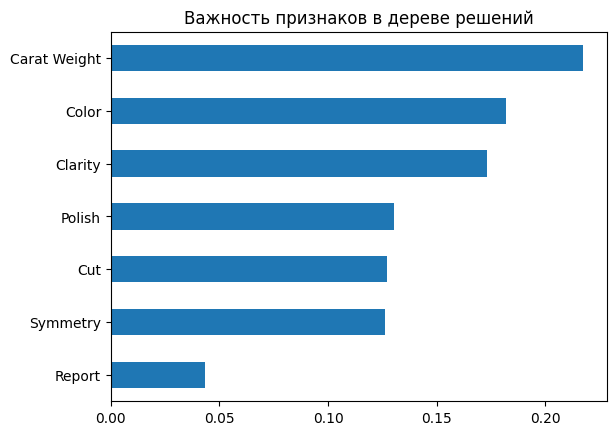

In [83]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

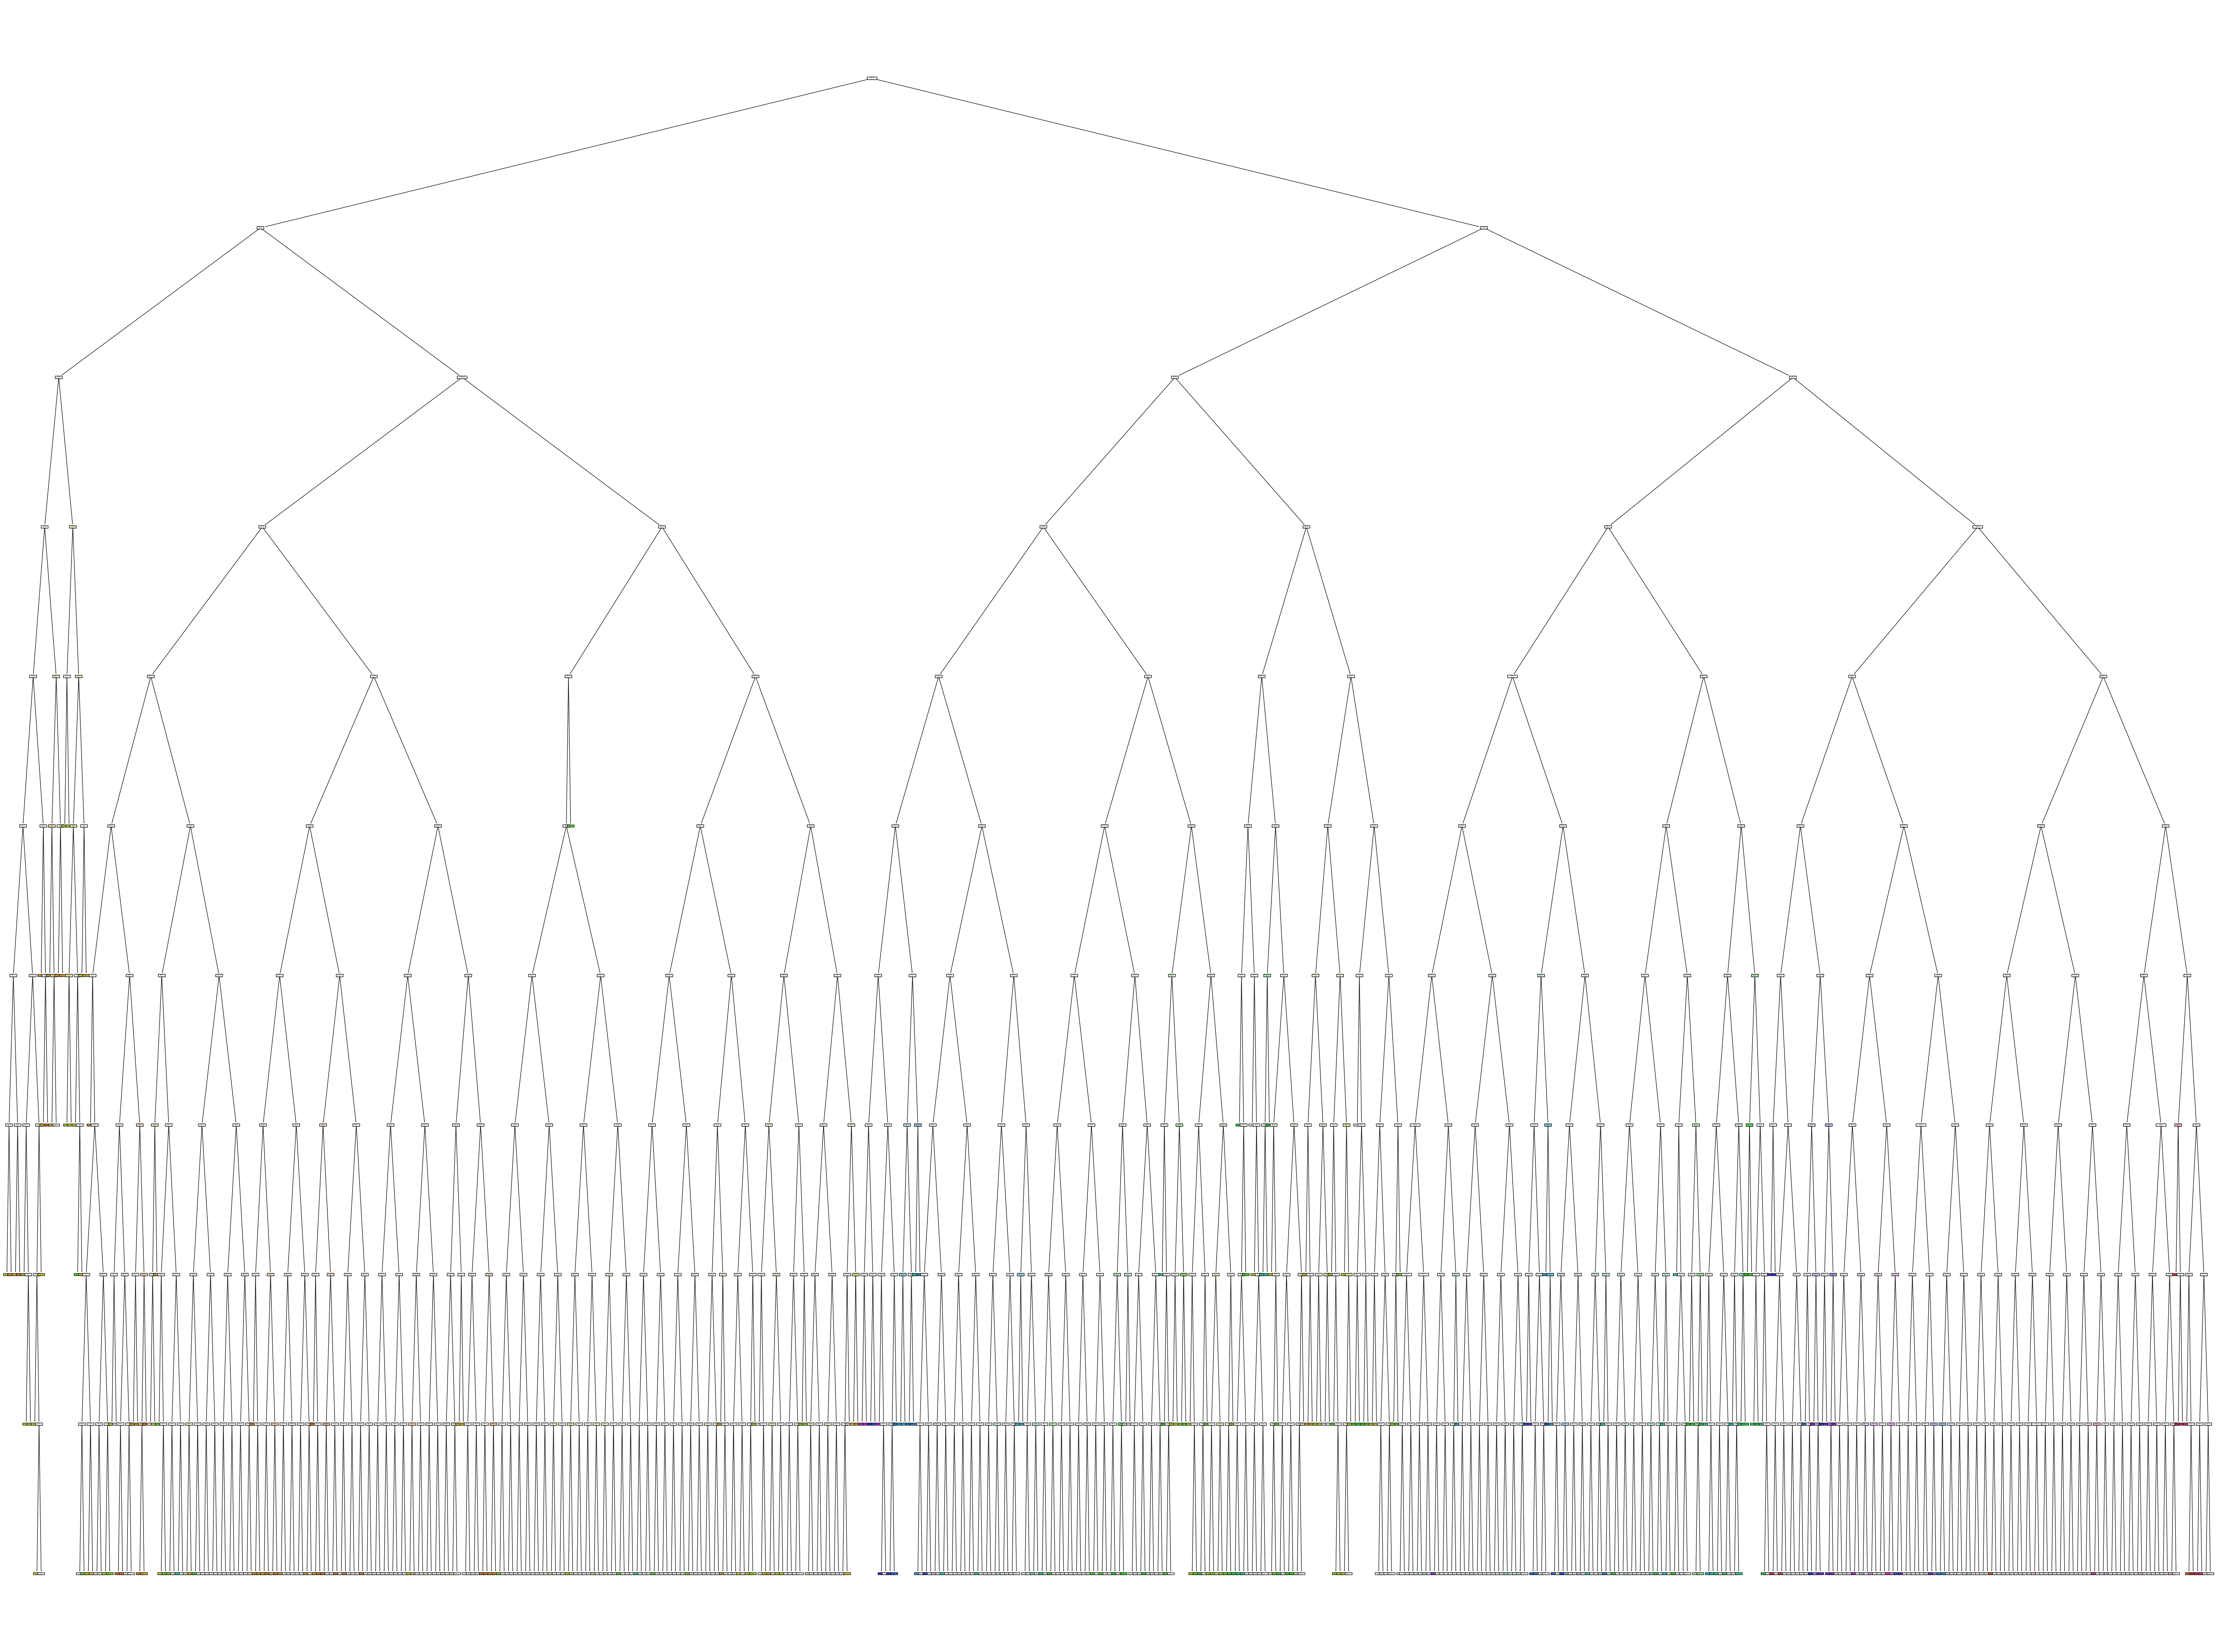

In [84]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()